# PyRoomAcoustics Room Simulator

Documentation: https://pyroomacoustics.readthedocs.io/en/pypi-release/pyroomacoustics.room.html#pyroomacoustics.room.Room.add

# Importing the relevant libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra

# Setting the dimensions of the room

Inverse Sabine's Formula: 

In [26]:
# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
from scipy.io import wavfile
fs, audio = wavfile.read('A440.wav')
# Take one channel of audio
audio = audio[:, 0]
print(audio)
# The desired reverberation time and dimensions of the room
rt60_tgt = 0.5   # seconds
room_dim = [5, 5, 5]  # meters
L = 1.28     # Distance between microphones (meters)
mic_h = 1    # Assume microphone is 1m from the ground

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order,
    use_rand_ism = True, max_rand_disp = 0.05
)

[ 0  0  0 ... 29 30 30]


# Adding sources

In [27]:
# Offsets from origin: Set a 1m offset from the origin
x_offset = 1
y_offset = 1

# Source position
source_pos = [x_offset + L/4, y_offset + np.sqrt(3)*L/4, mic_h]

# place the source in the room
room.add_source(source_pos, signal=audio)


# Adding Microphones

In [28]:
# Microphone positions
mic_1_pos  = [x_offset + 0, y_offset + 0, mic_h]
mic_2_pos  = [x_offset + L, y_offset + 0, mic_h]
mic_3_pos  = [x_offset + L/2, y_offset + np.sqrt(3)*L/2, mic_h]
mic_gt_pos = [x_offset + L/2,y_offset + np.sqrt(3)*L/4, mic_h]

# define the locations of the microphones
mic_locs = np.c_[
    mic_1_pos,  # mic 1
    mic_2_pos,  # mic 2
    mic_3_pos,  # mic 3
    mic_gt_pos  # ground truth microphone
]
print(mic_locs)
# finally place the array in the room
room.add_microphone_array(mic_locs)

[[1.         2.28       1.64       1.64      ]
 [1.         1.         2.10851252 1.55425626]
 [3.         3.         3.         3.        ]]


# Running the simulation
Note: This will build the RIR automatically

In [29]:
# Simulate the room
room.simulate()

# Output the microphone data to wav file format
room.mic_array.to_wav(
    f"generated_mics/mic_arr.wav",
    norm=True,
    bitdepth=np.int16,
)

# Creating the room impulse response

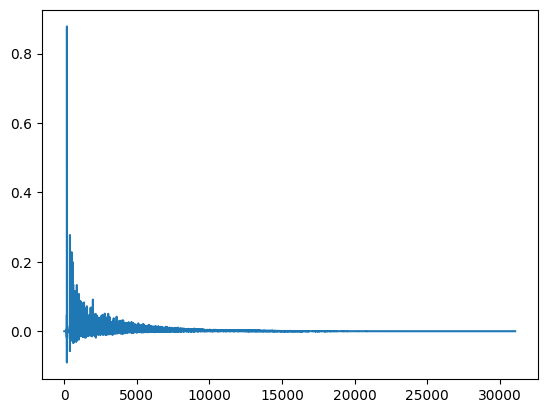

In [30]:
room.compute_rir()
plt.plot(room.rir[1][0])
plt.show()

# Plot the room output

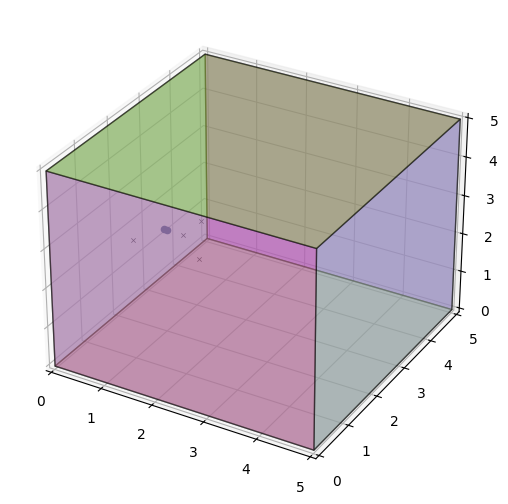

In [31]:
room.plot(img_order=0)
plt.show()

# Simulate sound propagation

The desired RT60 was 0.5
The measured RT60 is 0.5019727891156462


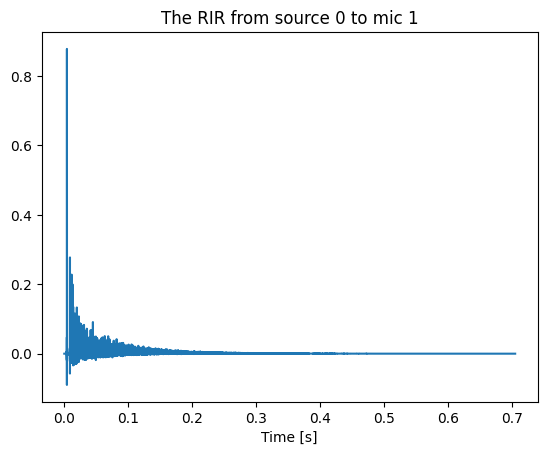

[[-2.51173483e-11 -5.58163294e-12 -5.58163294e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.85045460e-11  2.79081647e-11  3.17455374e-11 ...  6.41887789e-11
  -1.11632659e-11 -5.58163294e-12]
 [-1.95357153e-11 -3.62806141e-11 -2.23265318e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.86071459e-11  6.55841871e-11  4.74438800e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


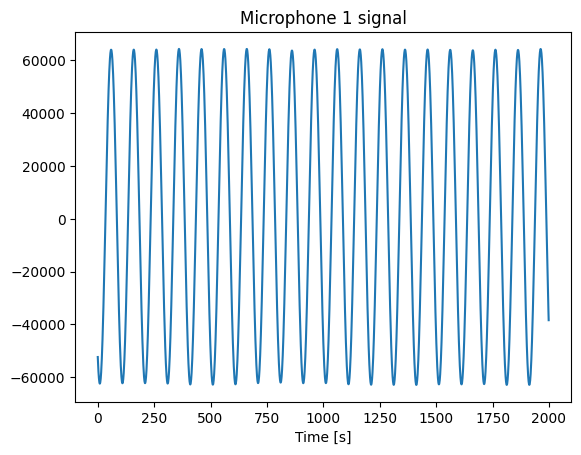

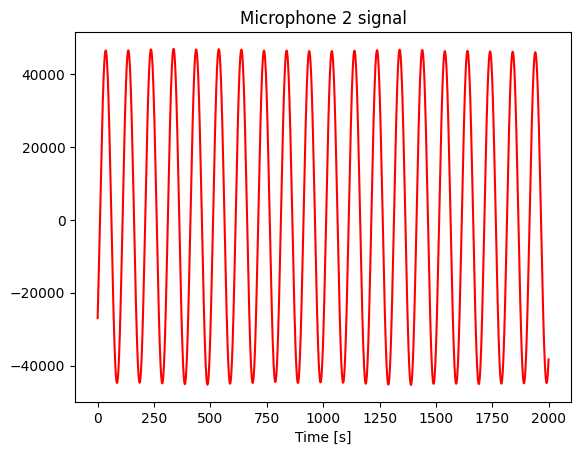

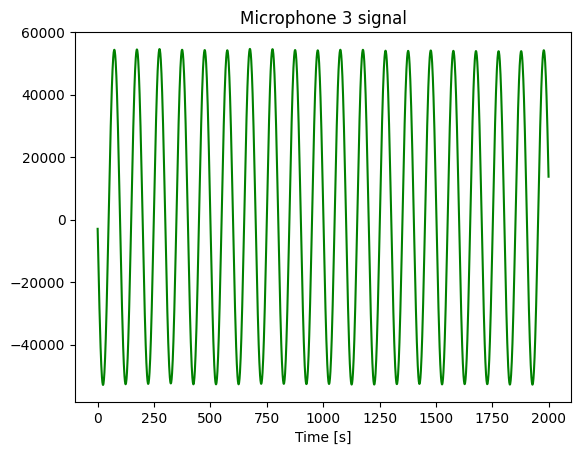

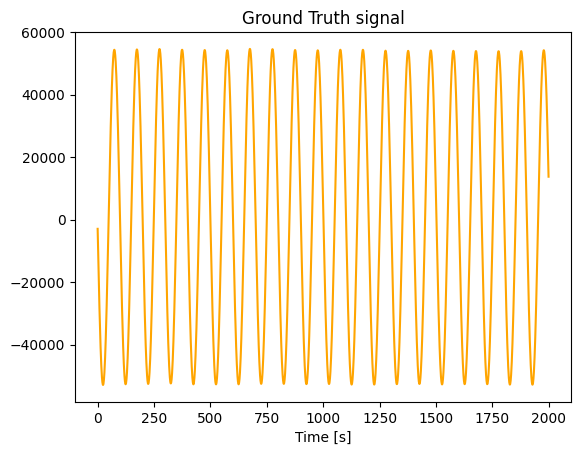

In [32]:
# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]
# plt.subplot(5, 1, 1)
plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")
plt.show()

# Plotting individual signals

start = 10000
end = 12000

print(room.mic_array.signals)

# plot signal at microphone 1
mic_1_signal = room.mic_array.signals[0, :]
mic_1_signal = mic_1_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 2)
plt.plot(mic_1_signal)
plt.title("Microphone 1 signal")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 2
mic_2_signal = room.mic_array.signals[1, :]
mic_2_signal = mic_2_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 3)
plt.plot(mic_2_signal, color='red')
plt.title("Microphone 2 signal")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 2
mic_3_signal = room.mic_array.signals[2, :]
mic_3_signal = mic_3_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 4)
plt.plot(mic_3_signal, color='green')
plt.title("Microphone 3 signal")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 2
gt_signal = room.mic_array.signals[3, :]
gt_signal = gt_signal[start:end]# Shorten the signal
# plt.subplot(5, 1, 5)
plt.plot(mic_3_signal, color='orange')
plt.title("Ground Truth signal")
plt.xlabel("Time [s]")
plt.show()